In [109]:
# ============================================================
# CAPSTONE NOTEBOOK — BANK CUSTOMER CHURN
# Logistic Regression (Baseline) vs XGBoost (Advanced)
# With: stratified split plots, confusion matrix plots,
# threshold tuning (optimize F1), ROC curve, feature importance,
# and save best pipeline model.
#
# Dataset: Churn_Modelling (1).csv
# Target : Exited (1=churn, 0=not churn)
# ============================================================

# =========================
# CELL 1 — Imports
# =========================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import (
    f1_score, roc_auc_score, confusion_matrix, classification_report,
    RocCurveDisplay, ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt
import joblib


In [110]:
# =========================
# CELL 2 — Load Dataset
# =========================
DATA_PATH = "Churn_Modelling.csv"  # ganti jika nama/path berbeda

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()


Shape: (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [111]:
# =========================
# CELL 3 — Quick Data Check
# =========================
print("Dtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

print("\nTarget distribution (Exited):")
print(df["Exited"].value_counts())
print("\nTarget distribution (%):")
print((df["Exited"].value_counts(normalize=True) * 100).round(2))


Dtypes:
 RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Missing values per column:
 RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Target distribution (Exited):
Exited
0    7963
1    2037
Name: count, dtype: int64

Target distribution (%):
Exited
0    79.63
1    20.37
Name: proportion, dtype: float64


In [112]:
# =========================
# CELL 4 — Define Features & Target
# =========================
TARGET = "Exited"
DROP_COLS = ["RowNumber", "CustomerId", "Surname"]  # kolom ID wajib drop

X = df.drop(columns=[TARGET] + DROP_COLS)
y = df[TARGET]

print("X shape:", X.shape, "| y shape:", y.shape)
X.head()


X shape: (10000, 10) | y shape: (10000,)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [113]:
# ==================================================
# CELL 5 — Train Test Split (Stratify penting)
# ==================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Train churn %:", (y_train.mean() * 100).round(2))
print("Test churn % :", (y_test.mean() * 100).round(2))


Train: (8000, 10)  Test: (2000, 10)
Train churn %: 20.38
Test churn % : 20.35


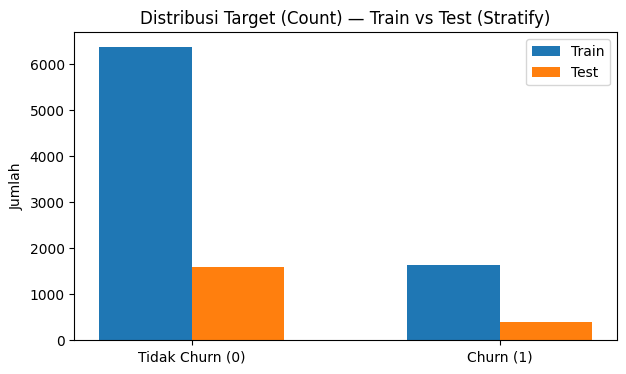

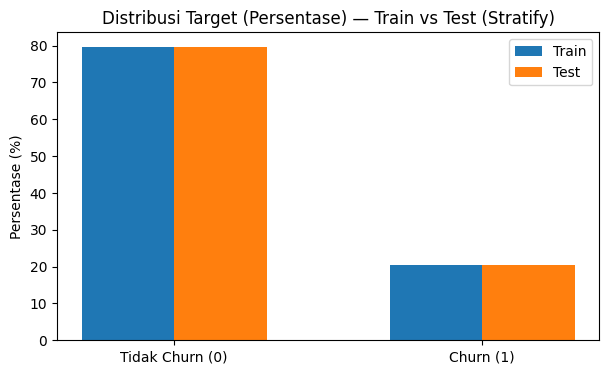

In [114]:
# ==================================================
# CELL 5A — Plot Distribusi Target Train vs Test
# ==================================================
train_counts = y_train.value_counts().sort_index()
test_counts  = y_test.value_counts().sort_index()

train_pct = (y_train.value_counts(normalize=True).sort_index() * 100)
test_pct  = (y_test.value_counts(normalize=True).sort_index() * 100)

labels = ["Tidak Churn (0)", "Churn (1)"]
x = np.arange(len(labels))

# Plot count
plt.figure(figsize=(7,4))
plt.bar(x - 0.15, train_counts.values, width=0.3, label="Train")
plt.bar(x + 0.15, test_counts.values,  width=0.3, label="Test")
plt.xticks(x, labels)
plt.ylabel("Jumlah")
plt.title("Distribusi Target (Count) — Train vs Test (Stratify)")
plt.legend()
plt.show()

# Plot percentage
plt.figure(figsize=(7,4))
plt.bar(x - 0.15, train_pct.values, width=0.3, label="Train")
plt.bar(x + 0.15, test_pct.values,  width=0.3, label="Test")
plt.xticks(x, labels)
plt.ylabel("Persentase (%)")
plt.title("Distribusi Target (Persentase) — Train vs Test (Stratify)")
plt.legend()
plt.show()


In [115]:
# ==================================================
# CELL 5B — Split internal Train/Val untuk Threshold Tuning
# (agar threshold tidak dioptimasi pakai test set)
# ==================================================
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.25,       # 0.25 dari train => val ~20% dari total data
    random_state=42,
    stratify=y_train
)

print("Train internal:", X_tr.shape, " Val:", X_val.shape)
print("Val churn %:", (y_val.mean() * 100).round(2))


Train internal: (6000, 10)  Val: (2000, 10)
Val churn %: 20.35


In [116]:
# =========================
# CELL 6 — Identify Column Types
# =========================
categorical_features = ["Geography", "Gender"]
numeric_features = [c for c in X.columns if c not in categorical_features]

print("Categorical:", categorical_features)
print("Numeric:", numeric_features)


Categorical: ['Geography', 'Gender']
Numeric: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [117]:
# ==================================================
# CELL 7 — Preprocessors
# OneHot untuk categorical
# Scaling hanya untuk Logistic Regression
# ==================================================
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess_for_lr = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", StandardScaler(), numeric_features),
    ],
    remainder="drop"
)

preprocess_for_xgb = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", "passthrough", numeric_features),
    ],
    remainder="drop"
)


In [118]:
# ==================================================
# CELL 8 — Build Pipelines (LR vs XGBoost)
# ==================================================

# Logistic Regression (baseline) + class_weight balanced
lr_model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=42
)

lr_pipeline = Pipeline(steps=[
    ("preprocess", preprocess_for_lr),
    ("model", lr_model)
])

# XGBoost (advanced) + scale_pos_weight
neg = (y_tr == 0).sum()
pos = (y_tr == 1).sum()
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1
)


xgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocess_for_xgb),
    ("model", xgb_model)
])


scale_pos_weight: 3.9059689288634507


In [119]:
# ==================================================
# CELL 9 — Helper Functions:
# - proba helper
# - threshold tuning (maximize F1 on validation)
# - evaluation with CM plot & ROC plot
# ==================================================
def predict_proba_positive(pipeline, X):
    """Return probability of positive class (churn=1)."""
    if hasattr(pipeline.named_steps["model"], "predict_proba"):
        return pipeline.predict_proba(X)[:, 1]
    else:
        scores = pipeline.decision_function(X)
        scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
        return scores

def find_best_threshold_for_f1(pipeline, X_fit, y_fit, X_val, y_val, grid=None):
    if grid is None:
        grid = np.linspace(0.05, 0.95, 19)

    pipeline.fit(X_fit, y_fit)
    proba_val = predict_proba_positive(pipeline, X_val)

    best_thr, best_f1 = 0.5, -1.0
    f1_list = []

    for thr in grid:
        pred_val = (proba_val >= thr).astype(int)
        f1 = f1_score(y_val, pred_val)
        f1_list.append((thr, f1))
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr

    return best_thr, best_f1, pd.DataFrame(f1_list, columns=["threshold", "f1"])

def evaluate_with_threshold(name, pipeline, X_fit, y_fit, X_eval, y_eval, threshold=0.5, plot_roc=True, plot_cm=True):
    pipeline.fit(X_fit, y_fit)

    y_proba = predict_proba_positive(pipeline, X_eval)
    y_pred = (y_proba >= threshold).astype(int)

    f1 = f1_score(y_eval, y_pred)
    auc = roc_auc_score(y_eval, y_proba)
    cm = confusion_matrix(y_eval, y_pred)

    print("=" * 70)
    print(f"MODEL: {name}")
    print("Threshold:", threshold)
    print("F1-Score:", round(f1, 4))
    print("ROC-AUC :", round(auc, 4))
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_eval, y_pred, digits=4))

    if plot_cm:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Tidak Churn (0)", "Churn (1)"])
        disp.plot(values_format="d")
        plt.title(f"Confusion Matrix — {name} (thr={threshold})")
        plt.show()

    if plot_roc:
        RocCurveDisplay.from_predictions(y_eval, y_proba)
        plt.title(f"ROC Curve — {name}")
        plt.show()

    return {
        "Model": name,
        "F1-Score": f1,
        "ROC-AUC": auc,
        "threshold": threshold,
        "TN": cm[0,0], "FP": cm[0,1],
        "FN": cm[1,0], "TP": cm[1,1],
        "pipeline": pipeline
    }


Best LR threshold: 0.5499999999999999 Val F1: 0.4859
Best XGB threshold: 0.5499999999999999 Val F1: 0.6341


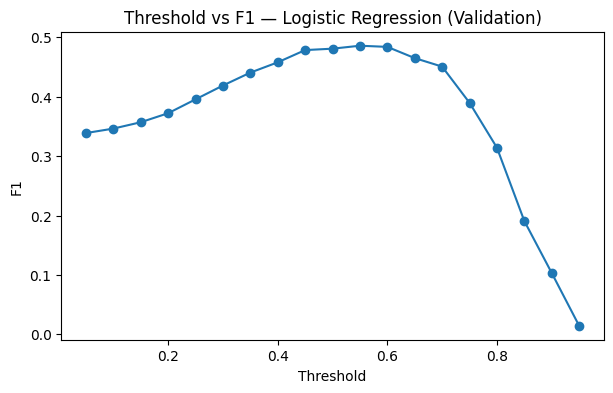

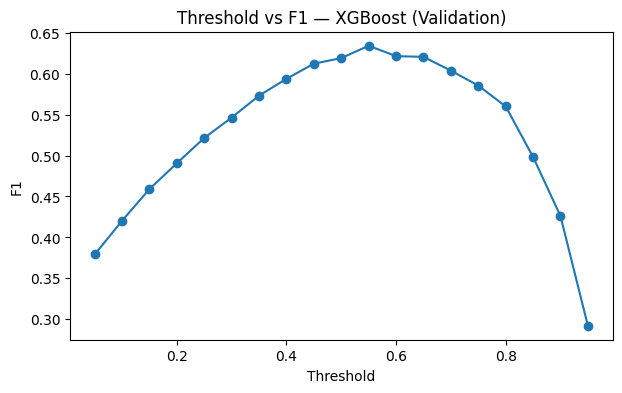

In [120]:
# ==================================================
# CELL 9A — Threshold Tuning on Validation Set
# ==================================================
best_thr_lr, best_f1_lr, lr_thr_table = find_best_threshold_for_f1(
    lr_pipeline, X_tr, y_tr, X_val, y_val
)

best_thr_xgb, best_f1_xgb, xgb_thr_table = find_best_threshold_for_f1(
    xgb_pipeline, X_tr, y_tr, X_val, y_val
)

print("Best LR threshold:", best_thr_lr, "Val F1:", round(best_f1_lr, 4))
print("Best XGB threshold:", best_thr_xgb, "Val F1:", round(best_f1_xgb, 4))

# Plot threshold vs F1 (LR)
plt.figure(figsize=(7,4))
plt.plot(lr_thr_table["threshold"], lr_thr_table["f1"], marker="o")
plt.title("Threshold vs F1 — Logistic Regression (Validation)")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.show()

# Plot threshold vs F1 (XGB)
plt.figure(figsize=(7,4))
plt.plot(xgb_thr_table["threshold"], xgb_thr_table["f1"], marker="o")
plt.title("Threshold vs F1 — XGBoost (Validation)")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.show()


MODEL: Logistic Regression (Baseline)
Threshold: 0.5499999999999999
F1-Score: 0.5099
ROC-AUC : 0.7775

Confusion Matrix:
 [[1246  347]
 [ 149  258]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8932    0.7822    0.8340      1593
           1     0.4264    0.6339    0.5099       407

    accuracy                         0.7520      2000
   macro avg     0.6598    0.7080    0.6719      2000
weighted avg     0.7982    0.7520    0.7680      2000



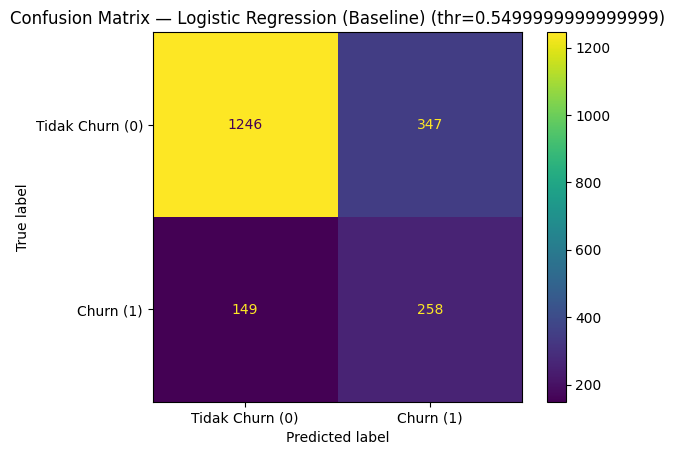

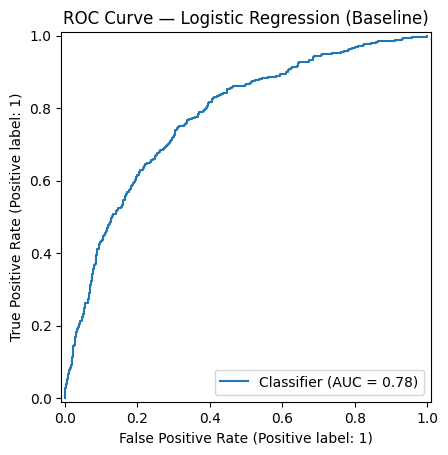

In [121]:
# ==================================================
# CELL 10 — Logistic Regression FINAL Evaluation on Test (with best threshold)
# Includes: Confusion Matrix Image + ROC
# ==================================================
result_lr = evaluate_with_threshold(
    name="Logistic Regression (Baseline)",
    pipeline=lr_pipeline,
    X_fit=X_tr, y_fit=y_tr,
    X_eval=X_test, y_eval=y_test,
    threshold=best_thr_lr,
    plot_roc=True,
    plot_cm=True
)


MODEL: XGBoost (Advanced)
Threshold: 0.5499999999999999
F1-Score: 0.5919
ROC-AUC : 0.8541

Confusion Matrix:
 [[1372  221]
 [ 143  264]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9056    0.8613    0.8829      1593
           1     0.5443    0.6486    0.5919       407

    accuracy                         0.8180      2000
   macro avg     0.7250    0.7550    0.7374      2000
weighted avg     0.8321    0.8180    0.8237      2000



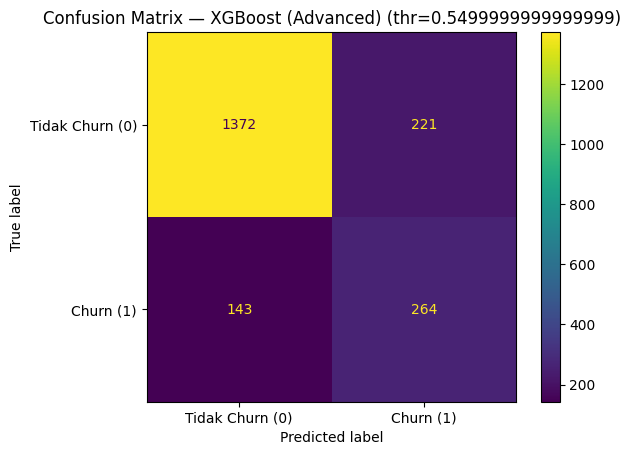

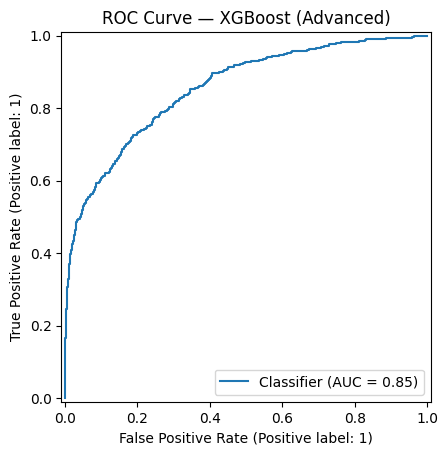

In [122]:
# ==================================================
# CELL 11 — XGBoost FINAL Evaluation on Test (with best threshold)
# Includes: Confusion Matrix Image + ROC
# ==================================================
result_xgb = evaluate_with_threshold(
    name="XGBoost (Advanced)",
    pipeline=xgb_pipeline,
    X_fit=X_tr, y_fit=y_tr,
    X_eval=X_test, y_eval=y_test,
    threshold=best_thr_xgb,
    plot_roc=True,
    plot_cm=True
)


In [123]:
# ==================================================
# CELL 12 — Compare Results Table
# ==================================================
compare_df = pd.DataFrame([
    {k: v for k, v in result_lr.items() if k != "pipeline"},
    {k: v for k, v in result_xgb.items() if k != "pipeline"},
])

compare_df = compare_df[["Model", "threshold", "F1-Score", "ROC-AUC", "TN", "FP", "FN", "TP"]]
compare_df.sort_values(by="F1-Score", ascending=False)


,Model,threshold,F1-Score,ROC-AUC,TN,FP,FN,TP
1,XGBoost (Advanced),0.55,0.591928,0.854076,1372,221,143,264
0,Logistic Regression (Baseline),0.55,0.509881,0.777526,1246,347,149,258


In [124]:
# ==================================================
# CELL 14 — Feature Importance (XGBoost) + Plot
# ==================================================
# NOTE:
# - Jika model terbaik ternyata Logistic Regression, FI tetap dihitung dari XGBoost
#   sebagai analisis tambahan karena LR tidak punya "feature importance" seperti tree.
# - Jika best model = XGBoost, FI diambil dari best XGBoost pipeline.

# Pastikan XGBoost sudah fit pada data train penuh
xgb_pipeline.fit(X_train, y_train)

xgb_estimator = xgb_pipeline.named_steps["model"]
preprocessor = xgb_pipeline.named_steps["preprocess"]
ohe = preprocessor.named_transformers_["cat"]

ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
all_feature_names = ohe_feature_names + numeric_features

importances = xgb_estimator.feature_importances_
fi = pd.DataFrame({"feature": all_feature_names, "importance": importances}).sort_values("importance", ascending=False)

display(fi.head(15))


,feature,importance
9,NumOfProducts,0.250535
11,IsActiveMember,0.148746
6,Age,0.137804
1,Geography_Germany,0.110623
3,Gender_Female,0.060691
8,Balance,0.053280
0,Geography_France,0.041986
4,Gender_Male,0.039464
2,Geography_Spain,0.037415
12,EstimatedSalary,0.031962


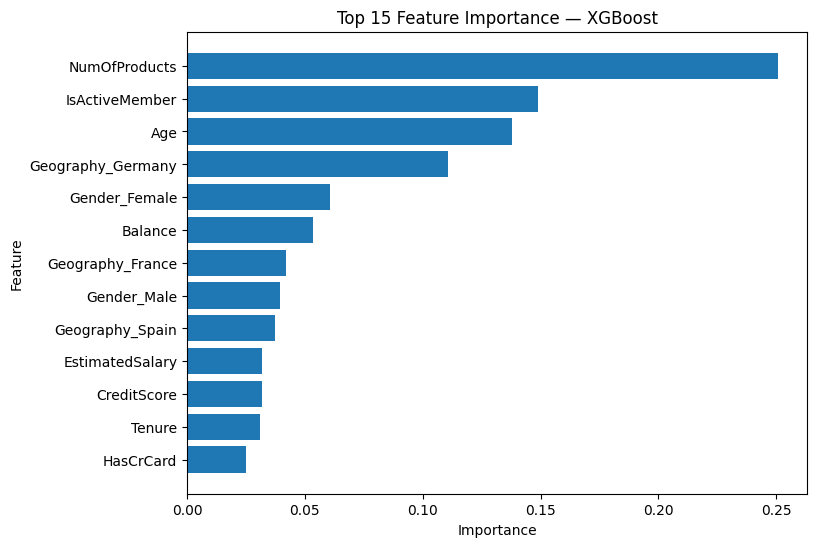

In [125]:
# =========================
# CELL 15 — Plot Top Feature Importances
# =========================
top_n = 15
fi_top = fi.head(top_n)[::-1]

plt.figure(figsize=(8,6))
plt.barh(fi_top["feature"], fi_top["importance"])
plt.title(f"Top {top_n} Feature Importance — XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [126]:
# ==================================================
# FINAL CELL — SAVE MODEL FOR FLASK DEPLOYMENT
# ==================================================

import json
import joblib

# --------------------------------------------------
# 1. Tentukan model terbaik berdasarkan F1-score TEST
# --------------------------------------------------
best_result = result_lr if result_lr["F1-Score"] >= result_xgb["F1-Score"] else result_xgb

best_model_name = best_result["Model"]
best_threshold = float(best_result["threshold"])
best_pipeline = best_result["pipeline"]

print("Selected best model :", best_model_name)
print("Best threshold (F1) :", best_threshold)

# --------------------------------------------------
# 2. FIT ULANG model terbaik dengan DATA TRAIN PENUH
# (agar model final lebih stabil & kuat)
# --------------------------------------------------
best_pipeline.fit(X_train, y_train)

# --------------------------------------------------
# 3. Simpan MODEL PIPELINE (untuk Flask)
# --------------------------------------------------
MODEL_FILE = "churn_model_pipeline.joblib"
joblib.dump(best_pipeline, MODEL_FILE)

print("Model pipeline saved to:", MODEL_FILE)

# --------------------------------------------------
# 4. Simpan METADATA (threshold + urutan fitur)
# --------------------------------------------------
metadata = {
    "model_name": best_model_name,
    "threshold": best_threshold,
    "feature_columns": list(X.columns),      # urutan input mentah dari Flask
    "categorical_features": categorical_features,
    "numeric_features": numeric_features
}

META_FILE = "churn_model_metadata.json"
with open(META_FILE, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)

print("Metadata saved to:", META_FILE)


Selected best model : XGBoost (Advanced)
Best threshold (F1) : 0.5499999999999999
Model pipeline saved to: churn_model_pipeline.joblib
Metadata saved to: churn_model_metadata.json


In [127]:
# ==================================================
# VERIFY SAVED MODEL — Flask Simulation
# ==================================================

import json
import joblib
import pandas as pd

# Load model & metadata
model = joblib.load("churn_model_pipeline.joblib")

with open("churn_model_metadata.json", "r", encoding="utf-8") as f:
    meta = json.load(f)

threshold = meta["threshold"]
feature_cols = meta["feature_columns"]

# Ambil 1 sampel data test
sample = X_test.iloc[[0]].copy()
sample = sample[feature_cols]  # pastikan urutan kolom benar

# Prediksi
prob_churn = model.predict_proba(sample)[:, 1][0]
predicted = int(prob_churn >= threshold)

print("Probability churn :", prob_churn)
print("Prediction        :", predicted, "(1=churn, 0=not churn)")
print("Actual label      :", int(y_test.iloc[0]))


Probability churn : 0.04447483
Prediction        : 0 (1=churn, 0=not churn)
Actual label      : 0
